# The QIIME2 Pipeline Artifacts Analysis

We will make analytical processing of the artifacts generated through the QIIME2's metagenomic pipeline.

---

# Environment setup and data preparation

Before starting the data analysis, we need to prepare and configure some computational resources.

Initially, we configure the environment by importing some programming libraries and functions of specific packages. After that, we will define some paths for working folders and files. Some custom functions are implemented here for modularization purposes.

In the next stage, we ingest some data artifacts and do transformations to load specific data formats and information to be used in the data analysis further.

## Setting the environment

### Importing packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pathlib import Path
import re
from qiime2.plugins import feature_table
from qiime2 import Artifact, Visualization
from qiime2 import Metadata
from qiime2.plugins.metadata.visualizers import tabulate
from qiime2.plugins.feature_table.methods import filter_samples
from qiime2.plugins.feature_table.methods import group
from qiime2.plugins.feature_table.methods import presence_absence
from qiime2.plugins.taxa.methods import collapse
from qiime2.plugins import metadata
from qiime2.plugins.feature_table.methods import filter_samples

#from qiime2.plugins import demux, dada2, deblur, quality_filter, metadata, feature_table, alignment, phylogeny, diversity, emperor, feature_classifier, taxa, composition

from IPython.display import display
%matplotlib inline

### Defining the parameters
The following cell can receive parameters using the [papermill](https://papermill.readthedocs.io/en/latest/) tool.

In [2]:
metadata_file = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', 'raw', 'metadata', 'not-hist-feces-metadata.tsv'))
experiment_folder = os.path.abspath(os.path.join(os.getcwd(), '..', 'experiments', 'thayane-feces-01'))
img_folder = os.path.abspath(os.path.join(experiment_folder, 'imgs'))
threads = 6

In [3]:
qiime_folder = os.path.join(experiment_folder, 'qiime-artifacts')
table_file = os.path.join(qiime_folder, 'dada2-tabs.qza')
taxon_file = os.path.join(qiime_folder, 'metatax.qza')

### Custom functions

In [4]:
def top_counts(df, col_idx):
    species = []
    counts = []
    full_tax = []
    cnt = 0
    for i, v in df[col_idx].sort_values(ascending=False).iteritems():
        sfield = i.split(';')[-1]
        if sfield != '__':
            cnt += 1
            species.append(sfield[3:])
            counts.append(int(v))
            full_tax.append(i)
        if cnt >= 10:
            break
    return species, counts, full_tax

---

## Data ingestion

### Ingesting the Metadata table

We're ingesting the metadata `TSV` file as a `Metadata` object of QIIME2 API.

In [5]:
# Ingest metadata tsv to qiime2.metadata.metadata.Metadata object
sample_metadata = Metadata.load(metadata_file)

# tabulate(sample_metadata).visualization
sample_metadata

Metadata
--------
66 IDs x 8 columns
s_name:          ColumnProperties(type='categorical')
observations:    ColumnProperties(type='categorical')
individuo:       ColumnProperties(type='categorical')
id_vaginal:      ColumnProperties(type='categorical')
id_fezes:        ColumnProperties(type='categorical')
local_de_coleta: ColumnProperties(type='categorical')
idade:           ColumnProperties(type='numeric')
class_meno:      ColumnProperties(type='categorical')

Call to_dataframe() for a tabular representation.

We are creating a `DataFrame` object of the `Metadata` artifact.

In [6]:
samples_df = sample_metadata.to_dataframe()

### Ingesting the complete ASV table

We're ingesting the ASV table with filtered features through the DADA2 algorithm. This artifact contains the absolute abundance of each ASV feature for all samples.

In [7]:
frequency_table_path = table_file
frequency_table = Artifact.load(frequency_table_path)
frequency_table

<artifact: FeatureTable[Frequency] uuid: d5ba9a95-3a4d-4abb-80f8-899291b5be2d>

### Filtering samples 

In [8]:
# Create the SQL statement
ids_to_filter_out = ('MV10', 'MV29', 'MV45', 'MV49', 'MV66', 'MV69', 'MV80', 'MV82', 'MV93', 'MV126', )
sql = ', '.join([f"'{x}'" for x in ids_to_filter_out])
sql = f'[id_vaginal] IN ({sql})'

frequency_table = filter_samples(
    table = frequency_table, 
    metadata = sample_metadata,
    where = sql,
    exclude_ids = True,
    filter_empty_features = True,
    min_frequency = 1,
    min_features = 1,
).filtered_table

samples_df = samples_df[~samples_df['id_vaginal'].isin(ids_to_filter_out)]

Here, we're generating the visualization of the complete ASV table.

In [9]:
#metadata.visualizers.tabulate(frequency_table.view(Metadata)).visualization

We're transforming the artifact `FeatureTable[Frequency]` to a Pandas `DataFrame` object to further processing using Python.

In [10]:
table_df = frequency_table.view(Metadata).to_dataframe().T
table_df

id,I1-M05,I10-M91,I11-M44,I12-M45,I13-M46,I14-M47,I15-M49,I16-M52,I17-M55,I18-M07,...,I68-M144,I69-M148,I7-M36,I70-M150,I71-M151,I72-M155,I73-M156,I75-M162,I76-M164,I8-M39
074b2d2eeb19288d75bf8e64784db602,0.0,786.0,0.0,1118.0,0.0,0.0,0.0,0.0,330.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1259.0,741.0,0.0,0.0,1263.0
6c3b33991621b6c3e04992794a55a3d9,0.0,1634.0,1228.0,1436.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1140.0,0.0,0.0,0.0,0.0,0.0,1427.0,0.0,0.0,773.0
8b7f2e8ca48676f3a47dfa784c8a9efe,0.0,540.0,0.0,872.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3095.0,0.0,0.0,0.0,0.0,0.0,0.0,652.0
7a1d4d3ec513655bbe964c4ab022e6fe,0.0,0.0,444.0,0.0,52.0,574.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,568.0,726.0,1033.0,315.0,0.0
b53b25874d0529b37d36bfc78e32c894,0.0,1464.0,1300.0,1210.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1318.0,0.0,2022.0,621.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ee5a1924a299e186d7f904e5aa898bd1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143582bcba9a90e4a585ed60042a6f0d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c713157aa6936b23861463951dfb6a3b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
bd157fd42be3b6728d0080ee52836c14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Ingesting the complete **Taxonomy** artifact

We ingest the complete `FeatureData[Taxonomy]` artifact. This file contains all inferred taxonomies for each feature as the associated confidence score.

In [11]:
taxon_path = taxon_file
table_tax = Artifact.load(taxon_path)
table_tax

<artifact: FeatureData[Taxonomy] uuid: 77490e83-8c5f-44d2-9360-5fcbe79fe7d5>

We are generating a visualization of the new Taxonomy table with all inferred taxonomies of all features.

In [12]:
# metadata.visualizers.tabulate(table_tax.view(Metadata)).visualization

We're transforming the artifact `FeatureTable[Taxonomy]` to a Pandas `DataFrame` object to further processing using Python.

In [13]:
table_tax_df = table_tax.view(Metadata).to_dataframe()

### Get samples IDs by menopause class

In [14]:
samples_by_class = {k: samples_df[samples_df['class_meno']==str(k)].index.to_list() 
     for k in range(0,3)}

### Transforming the taxonomy Dataframe by expanding taxonomic columns

The Taxonomy column contains values as a string with all the inferred taxonomy levels. So, we transform these values by splitting the string and separating each taxonomy level into a new column.

We are using the following taxonomic level names: `Reino`, `Filo`, `Classe`, `Ordem`, `Família`, `Gênero`, `Espécie`.

In [15]:
tax_levels = ['Reino', 'Filo', 'Classe', 'Ordem', 'Família', 'Gênero', 'Espécie']
tax_levels = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
table_tax_df[tax_levels] = table_tax_df['Taxon'].str.split(';', expand=True)

---

# Data Analisys

## Taxononomy Table

### Inferred taxonomy numbers

We will count the numbers of inferred taxonomy for each taxonomic level.

First, we generate a new Dataframe by merging the complete taxonomic table with features IDs of **swab vaginal** samples.

In [16]:
table_cnt_tax_df = pd.merge(table_df, table_tax_df, left_index=True, right_index=True)
table_cnt_tax_df

,I1-M05,I10-M91,I11-M44,I12-M45,I13-M46,I14-M47,I15-M49,I16-M52,I17-M55,I18-M07,...,I8-M39,Taxon,Confidence,Kingdom,Phylum,Class,Order,Family,Genus,Species
074b2d2eeb19288d75bf8e64784db602,0.0,786.0,0.0,1118.0,0.0,0.0,0.0,0.0,330.0,0.0,...,1263.0,d__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.9361387167487187,d__Bacteria,p__Firmicutes,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__Agathobacter,None
6c3b33991621b6c3e04992794a55a3d9,0.0,1634.0,1228.0,1436.0,0.0,0.0,0.0,0.0,0.0,0.0,...,773.0,d__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.9069445037484893,d__Bacteria,p__Firmicutes,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__Agathobacter,None
8b7f2e8ca48676f3a47dfa784c8a9efe,0.0,540.0,0.0,872.0,0.0,0.0,0.0,0.0,0.0,0.0,...,652.0,d__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.9999025048147963,d__Bacteria,p__Firmicutes,c__Clostridia,o__Oscillospirales,f__Ruminococcaceae,g__Faecalibacterium,None
7a1d4d3ec513655bbe964c4ab022e6fe,0.0,0.0,444.0,0.0,52.0,574.0,0.0,0.0,0.0,0.0,...,0.0,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,0.7348376775850926,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae,g__Bacteroides,s__Bacteroides_vulgatus
b53b25874d0529b37d36bfc78e32c894,0.0,1464.0,1300.0,1210.0,0.0,0.0,0.0,0.0,0.0,0.0,...,621.0,d__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.9210205535092991,d__Bacteria,p__Firmicutes,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__Agathobacter,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ee5a1924a299e186d7f904e5aa898bd1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,d__Bacteria; p__Firmicutes; c__Negativicutes; ...,0.9990948331078099,d__Bacteria,p__Firmicutes,c__Negativicutes,o__Veillonellales-Selenomonadales,f__Veillonellaceae,g__Dialister,None
143582bcba9a90e4a585ed60042a6f0d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,d__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.8940617497317686,d__Bacteria,p__Firmicutes,c__Clostridia,o__Oscillospirales,f__Ruminococcaceae,g__Ruminococcus,None
c713157aa6936b23861463951dfb6a3b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,d__Bacteria; p__Firmicutes; c__Bacilli; o__Ery...,0.9997641168791319,d__Bacteria,p__Firmicutes,c__Bacilli,o__Erysipelotrichales,f__Erysipelotrichaceae,g__Holdemanella,None
bd157fd42be3b6728d0080ee52836c14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,d__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.9995510110548353,d__Bacteria,p__Firmicutes,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__Lachnospiraceae_UCG-010,s__uncultured_organism


Now, we show the number of inferred taxons by taxonomic level.

In [17]:
tmp = table_cnt_tax_df[samples_by_class[0]].sum(axis=1)
table_cnt_tax_df[tmp!=0]

,I1-M05,I10-M91,I11-M44,I12-M45,I13-M46,I14-M47,I15-M49,I16-M52,I17-M55,I18-M07,...,I8-M39,Taxon,Confidence,Kingdom,Phylum,Class,Order,Family,Genus,Species
074b2d2eeb19288d75bf8e64784db602,0.0,786.0,0.0,1118.0,0.0,0.0,0.0,0.0,330.0,0.0,...,1263.0,d__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.9361387167487187,d__Bacteria,p__Firmicutes,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__Agathobacter,None
6c3b33991621b6c3e04992794a55a3d9,0.0,1634.0,1228.0,1436.0,0.0,0.0,0.0,0.0,0.0,0.0,...,773.0,d__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.9069445037484893,d__Bacteria,p__Firmicutes,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__Agathobacter,None
8b7f2e8ca48676f3a47dfa784c8a9efe,0.0,540.0,0.0,872.0,0.0,0.0,0.0,0.0,0.0,0.0,...,652.0,d__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.9999025048147963,d__Bacteria,p__Firmicutes,c__Clostridia,o__Oscillospirales,f__Ruminococcaceae,g__Faecalibacterium,None
7a1d4d3ec513655bbe964c4ab022e6fe,0.0,0.0,444.0,0.0,52.0,574.0,0.0,0.0,0.0,0.0,...,0.0,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,0.7348376775850926,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae,g__Bacteroides,s__Bacteroides_vulgatus
b53b25874d0529b37d36bfc78e32c894,0.0,1464.0,1300.0,1210.0,0.0,0.0,0.0,0.0,0.0,0.0,...,621.0,d__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.9210205535092991,d__Bacteria,p__Firmicutes,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__Agathobacter,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2768bae087d0fb10cbf8a486a444b931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,0.8105951408678893,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Prevotellaceae,g__Prevotella,s__uncultured_bacterium
f2ee0f6b708acf2284739b07bfb8a910,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,d__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.9999342140386148,d__Bacteria,p__Firmicutes,c__Clostridia,o__Oscillospirales,f__Ruminococcaceae,g__Incertae_Sedis,None
440b18f112d726951157996929988d38,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,d__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.9993214202378717,d__Bacteria,p__Firmicutes,c__Clostridia,o__Oscillospirales,f__Ruminococcaceae,g__Subdoligranulum,None
fa52840a8948f2b92eb37f273c919b00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,0.9998913455939266,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae,g__Bacteroides,None


In [18]:
unique_taxons = {l: list(filter(None, table_cnt_tax_df[l].unique())) for l in tax_levels}
unique_taxons_counts_df = pd.DataFrame({x: [len(y)] for x, y in unique_taxons.items()}, index=['#Taxons'])
unique_taxons_counts_df
# print('--- Taxonomies found in the fezes ASV table ---')
# for k, v in unique_taxons.items():
#     print(f'{k}: {len(v)}')

,Kingdom,Phylum,Class,Order,Family,Genus,Species
#Taxons,3,10,14,30,53,137,96


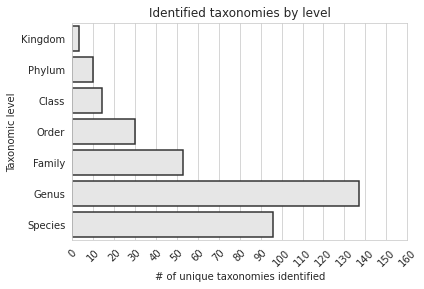

In [19]:
df = pd.DataFrame({'levels': tax_levels,
                  'counts': [len(x) for x in unique_taxons.values()]})
sns.set_style("whitegrid")
dbplot = sns.barplot(x='counts', y='levels', data=df, linewidth=1.5, 
                     facecolor=(.9, .9, .9, 1), errcolor=".2", edgecolor=".2")
dbplot.set(xlabel="# of unique taxonomies identified", ylabel="Taxonomic level", title = "Identified taxonomies by level")
plt.xticks(np.arange(0, 170, 10))
plt.xticks(rotation=45)
plt.show()

### Inferred taxonomy confidence

Now, we describe a summary analysis of the inferred confidence statistics. We show the total number of inferred taxonomies, the mean confidence and the standard deviation, the maximum and the minimum confidence score found, and the quartiles.

In [20]:
table_tax_df['Confidence'].astype('float32').describe()

count    2918.000000
mean        0.942491
std         0.083970
min         0.413501
25%         0.909087
50%         0.989604
75%         0.999950
max         1.000000
Name: Confidence, dtype: float64

We present a list with all unique inferred taxonomic names at each taxonomic level. The names are ordered in alphabetical order. 

In [21]:
print('--- Taxonomies found in each taxonomic level ---\n')
for k, v in unique_taxons.items():
    print(f'>>> {k.upper()}:\n{sorted([(x).strip()[3:] for x in v])}\n')

--- Taxonomies found in each taxonomic level ---

>>> KINGDOM:
['Archaea', 'Bacteria', 'ssigned']

>>> PHYLUM:
['Actinobacteriota', 'Bacteroidota', 'Cyanobacteria', 'Desulfobacterota', 'Elusimicrobiota', 'Euryarchaeota', 'Firmicutes', 'Fusobacteriota', 'Proteobacteria', 'Verrucomicrobiota']

>>> CLASS:
['Actinobacteria', 'Alphaproteobacteria', 'Bacilli', 'Bacteroidia', 'Clostridia', 'Coriobacteriia', 'Desulfovibrionia', 'Elusimicrobia', 'Fusobacteriia', 'Gammaproteobacteria', 'Methanobacteria', 'Negativicutes', 'Vampirivibrionia', 'Verrucomicrobiae']

>>> ORDER:
['Acidaminococcales', 'Aeromonadales', 'Bacteroidales', 'Bifidobacteriales', 'Burkholderiales', 'Christensenellales', 'Clostridia_UCG-014', 'Clostridia_vadinBB60_group', 'Clostridiales', 'Coriobacteriales', 'Desulfovibrionales', 'Elusimicrobiales', 'Enterobacterales', 'Erysipelotrichales', 'Fusobacteriales', 'Gastranaerophilales', 'Lachnospirales', 'Lactobacillales', 'Methanobacteriales', 'Monoglobales', 'Opitutales', 'Oscillos

---

## Analyzing Samples

### Abundances

Viewing the total number of samples

In [22]:
print(f'Number of samples in fezes ASV: {len(table_df.columns)}')

Number of samples in fezes ASV: 66


Samples with greater microbiological abundance in *fezes* ASV.

In [23]:
table_df.sum().sort_values(ascending=False)[:10]

id
I52-M117    102690.0
I51-M116     86625.0
I24-M67      85448.0
I36-M93      82751.0
I10-M91      80208.0
I8-M39       78374.0
I11-M44      77125.0
I17-M55      76017.0
I55-M122     75836.0
I34-M88      74714.0
dtype: float64

Viewing basic sample statistics in *fezes* ASV.

In [24]:
table_df.sum().describe()

count        66.000000
mean      41599.121212
std       24871.870661
min         590.000000
25%       21810.500000
50%       37042.500000
75%       63412.000000
max      102690.000000
dtype: float64

Plotting frequency distribution for all samples abundances in *fezes* ASV.

In [25]:
table_df.sum().sort_values()

id
I18-M07        590.0
I1-M05        1584.0
I39-M98       5182.0
I43-M103      7323.0
I16-M52       8005.0
              ...   
I10-M91      80208.0
I36-M93      82751.0
I24-M67      85448.0
I51-M116     86625.0
I52-M117    102690.0
Length: 66, dtype: float64

<AxesSubplot:xlabel='id'>

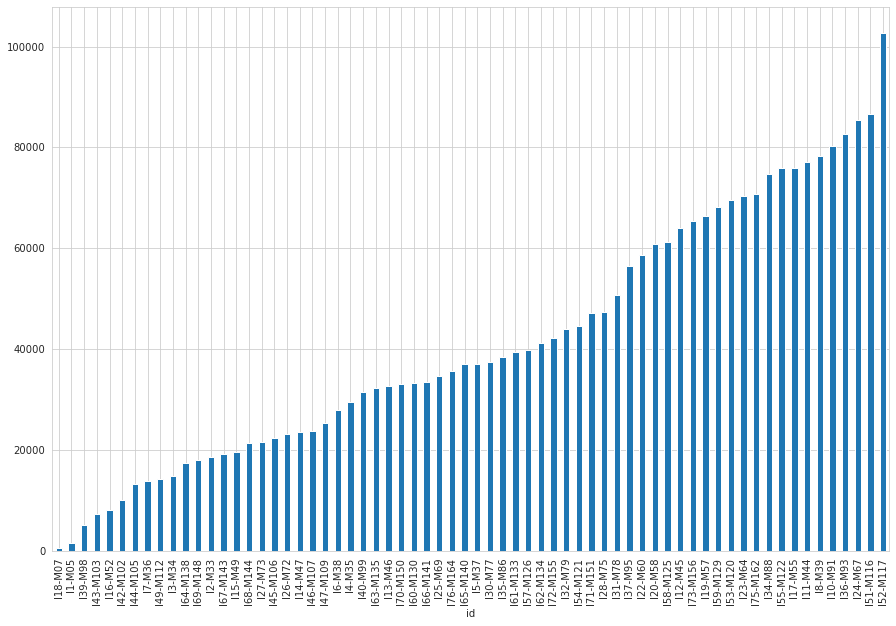

In [26]:
table_df.sum().sort_values().plot(kind='bar', figsize=(15,10))

### Diversities

Convert frequencies to binary values indicating presence or absence of a feature in a sample.

In [27]:
presence_absence_table = presence_absence(frequency_table).presence_absence_table
presence_absence_table

<artifact: FeatureTable[PresenceAbsence] uuid: 54110c88-297f-43aa-bcee-23f0dd50a829>

Transforming to Pandas DataFrame object

In [28]:
presence_absence_table_df = presence_absence_table.view(Metadata).to_dataframe().T

Top most diversities samples in *fezes* ASV.

In [29]:
presence_absence_table_df.sum().sort_values(ascending=False)[:10]

id
I51-M116    144.0
I8-M39      117.0
I24-M67     108.0
I17-M55     107.0
I11-M44     104.0
I10-M91     101.0
I36-M93      96.0
I23-M64      96.0
I52-M117     91.0
I75-M162     86.0
dtype: float64

Viewing basic sample statistics for *fezes* ASV.

In [30]:
presence_absence_table_df.sum().describe()

count     66.000000
mean      52.318182
std       30.393906
min        1.000000
25%       28.250000
50%       46.000000
75%       71.500000
max      144.000000
dtype: float64

Plotting frequency distribution for all *fezes* samples diversities.

<AxesSubplot:xlabel='id'>

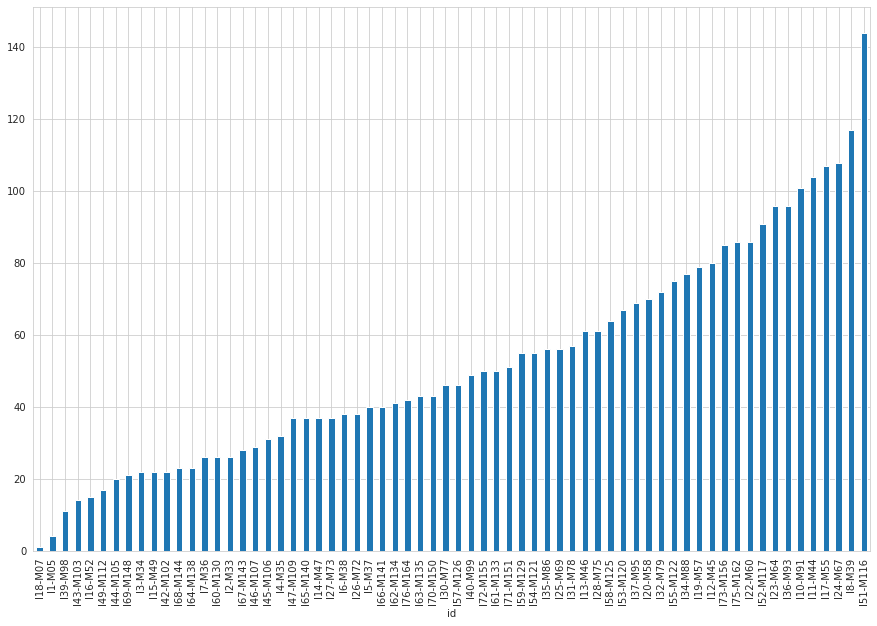

In [31]:
presence_absence_table_df.sum().sort_values().plot(kind='bar', figsize=(15,10))

---

## Analyzing Groups

### Microorganisms **abundances**

In [32]:
features_df = table_df.sum(axis=1)

<AxesSubplot:>

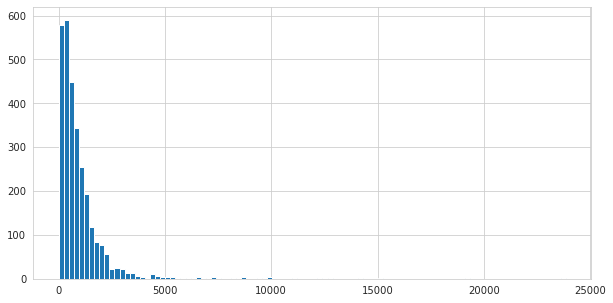

In [33]:
features_df.hist(bins=100, figsize=(10,5))

In [34]:
# Define pivot column for grouping function
sample_metadata.get_column('class_meno')
# Perform group by applying sum function
grouped_table = group(frequency_table, metadata=sample_metadata.get_column('class_meno'), axis='sample', mode='sum').grouped_table

Transforming to Pandas DataFrame object

In [35]:
grouped_table_df = grouped_table.view(Metadata).to_dataframe().sort_values(by='id')
grouped_table_df

,074b2d2eeb19288d75bf8e64784db602,6c3b33991621b6c3e04992794a55a3d9,8b7f2e8ca48676f3a47dfa784c8a9efe,7a1d4d3ec513655bbe964c4ab022e6fe,b53b25874d0529b37d36bfc78e32c894,de1dfedd96859b1568df4edfc30dff9b,9182301e1a42f09bd5016aad44496c4a,3689595a73bd93c0301ac8956a15279e,53df627adf8340f26a37202ed7374f2e,a835129fb0fba121225f939f51049a86,...,440b18f112d726951157996929988d38,fa52840a8948f2b92eb37f273c919b00,890138d5a18e44b8337f1c60308d82a8,08c2a6ae87899aa52af5b1e4e706bca7,0c2c4652d0d65b835d97dddca0b3a102,ee5a1924a299e186d7f904e5aa898bd1,143582bcba9a90e4a585ed60042a6f0d,c713157aa6936b23861463951dfb6a3b,bd157fd42be3b6728d0080ee52836c14,7be16af1fd4a487fd9e6380727a69555
id,,,,,,,,,,,,,,,,,,,,,
0,8533.0,3018.0,3783.0,3200.0,1464.0,0.0,1958.0,1548.0,3901.0,954.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7042.0,3794.0,2615.0,3616.0,3232.0,5126.0,2612.0,4866.0,1310.0,3658.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,8283.0,12499.0,8729.0,7407.0,8095.0,7234.0,6564.0,3589.0,4740.0,5207.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0


## Microorganisms Taxonomy **abundances**

In [36]:
# Define function to create abundances dataframes
def abundance_rank(tab, tax, lvl=7):
    """ Generate a Pandas DataFrame with abundances data and simple 
    descriptive metrics for valid taxonomy inferences. 
    
    Parameters
    ----------
    tab : FeatureTable[Frequency]
        An Qiime2 API artifact of type FeatureTable[Frequency]
    tax : FeatureData[Taxonomy]
        An Qiime2 API artifact of type FeatureData[Taxonomy]
    lvl : int
        The level to collapse the taxonomy (default is 7)
        
    Returns
    -------
    list
        a Pandas DataFrame with abundance data
    """
    from qiime2 import Metadata

    # Define local variables
    tax_prefix = ['d', 'p', 'c', 'o', 'f', 'g', 's'][lvl-1]
    idx_class = tab.view(Metadata).to_dataframe().index # Class Variables Columns Index
    
    # Generate the collapsed table for selected level
    collapsed_table = collapse(tab, taxonomy=tax, level=lvl).collapsed_table
    df = collapsed_table.view(Metadata).to_dataframe().T.sort_values(by='id', axis=1)

    # Filter out spuriuous inferences
    idx_non_valid_tax = df.index.str.endswith('__')
    valid_tax = df[~idx_non_valid_tax]
    idx_non_valid_tax = valid_tax.index.str.contains(f'{tax_prefix}__uncultured', regex=False)
    valid_tax = valid_tax[~idx_non_valid_tax]
    idx_non_valid_tax = valid_tax.index.str.contains('metagenome', regex=False)
    valid_tax = valid_tax[~idx_non_valid_tax]
    idx_non_valid_tax = valid_tax.index.str.contains(f'{tax_prefix}__human_gut', regex=False)
    valid_tax = valid_tax[~idx_non_valid_tax]
    idx_non_valid_tax = valid_tax.index.str.contains(f'{tax_prefix}__unidentified', regex=False)
    valid_tax = valid_tax[~idx_non_valid_tax]

    # Generate aggregation metrics
    valid_tax['total'] = valid_tax[idx_class].sum(axis=1) # Calculate the sum
    valid_tax['mean'] = valid_tax[idx_class].mean(axis=1) # Calculate the average
    valid_tax['std'] = valid_tax[idx_class].std(axis=1) # Calculate the standard deviation

    return valid_tax

In [37]:
def abundance_spreadsheet(path, tab, tax):
    tax_lvls = ['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species'] # Taxonomy levels
    idxs = tab.view(Metadata).to_dataframe().index.tolist()
    
    # Create an abundance DataFrame for each taxonomy level
    abundances = {lvl: abundance_rank(tab, tax, lvl=i+1) for i, lvl in enumerate(tax_lvls)}
    
    # Create a Pandas Excel writer using XlsxWriter as the engine.
    with pd.ExcelWriter(path, engine='xlsxwriter') as writer:
        totals = dict()
        for lvl in tax_lvls:  # Iterate over all Taxonomy levels
            abundances[lvl].to_excel(writer, sheet_name=lvl) # Write current DataFrame to a new sheet
            totals[lvl] = list()
            for i in idxs:
                col = abundances[lvl][i]
                val = col[col != 0].count()
                totals[lvl].append(val)
            totals[lvl].append(len(abundances[lvl]))
        totals = pd.DataFrame(totals, index=idxs+['All'])
        totals.to_excel(writer, sheet_name='TaxonsByLevel') # Write the number of unique taxons
    return abundances, totals

In [38]:
# === Abundances by woman SAMPLES ===

# Define the spreadsheet file path
abundances_by_class_path = os.path.join(experiment_folder, 'abundances_by_samples.xlsx') 

# Create an Excel spreadsheet with abundances informations for all taxonomy levels
abundances, totals = abundance_spreadsheet(abundances_by_class_path, frequency_table, table_tax)

In [82]:
tax_level = 'Genus'

species_names = [i.split(';')[-1][3:] for i in abundances[tax_level].index]
abundances[tax_level]['name'] = species_names

df_tmp = abundances[tax_level][['name', '0', '1', '2', 'total']]
df_tmp = df_tmp.astype({x:int for x in ('0','1','2','total')})
df_tmp = df_tmp.rename(columns={'name':tax_level, '0':'Reprodutivo', '1': 'Transição', '2':'Pós-menopausa', 'total':'Interseção'})

pivot = 'Interseção'
top = 11
print(df_tmp.sort_values(by=pivot, ascending=False)[:top].to_latex(index=False, caption=f'A Tabela apresenta as {top} espécies mais abundantes encontradas na interseção das três fases do ciclo reprodutivo. As linhas estão ordenada em ordem decrescente de acordo com a abundância da coluna "Interseção". São mostradas também as abundâncias de cada espécie em cada uma das fases.'))

\begin{table}
\centering
\caption{A Tabela apresenta as 11 espécies mais abundantes encontradas na interseção das três fases do ciclo reprodutivo. As linhas estão ordenada em ordem decrescente de acordo com a abundância da coluna "Interseção". São mostradas também as abundâncias de cada espécie em cada uma das fases.}
\begin{tabular}{lrrrr}
\toprule
                                Genus &  Reprodutivo &  Transição &  Pós-menopausa &  Interseção \\
\midrule
                          Bacteroides &        37370 &      83937 &         184439 &      305746 \\
                     Faecalibacterium &        37362 &      35413 &          98727 &      171502 \\
                              UCG-002 &        30040 &      19578 &          55022 &      104640 \\
                         Agathobacter &        19047 &      20233 &          58707 &       97987 \\
                           Prevotella &        27761 &      20439 &          45257 &       93457 \\
        Christensenellaceae\_R-7\_group

In [39]:
# === Abundances by menopause CLASSES ===

# Define the spreadsheet file path
abundances_by_class_path = os.path.join(experiment_folder, 'abundances_by_class.xlsx') 

# Create an Excel spreadsheet with abundances informations for all taxonomy levels
abundances, totals = abundance_spreadsheet(abundances_by_class_path, grouped_table, table_tax)

### Microorganisms frequences

In [40]:
freq_df = presence_absence_table_df.sum(axis=1).to_frame()
tax_freq_df = pd.merge(freq_df, table_tax_df, left_index=True, right_index=True)
tax_freq_df.rename(columns={0: 'Frequency'}, inplace=True)
tax_freq_df.sort_values(by=['Frequency'], ascending=False, inplace=True)
tax_freq_df.dropna()[:10]

,Frequency,Taxon,Confidence,Kingdom,Phylum,Class,Order,Family,Genus,Species
7a1d4d3ec513655bbe964c4ab022e6fe,17.0,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,0.7348376775850926,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae,g__Bacteroides,s__Bacteroides_vulgatus
84c637ccc4b3a7ddf249683f94a9e6b8,7.0,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,0.80958025129418,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae,g__Bacteroides,s__Bacteroides_vulgatus
94d998377d1b0778de2a8369a12f7c61,7.0,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,0.7456998849690256,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae,g__Bacteroides,s__Bacteroides_vulgatus
8888e1f1a4f7c14ed50b43769cacf02f,6.0,d__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.7357499647767276,d__Bacteria,p__Firmicutes,c__Clostridia,o__Oscillospirales,f__Ruminococcaceae,g__Subdoligranulum,s__uncultured_bacterium
9182301e1a42f09bd5016aad44496c4a,6.0,d__Bacteria; p__Firmicutes; c__Negativicutes; ...,0.8566238192342637,d__Bacteria,p__Firmicutes,c__Negativicutes,o__Veillonellales-Selenomonadales,f__Veillonellaceae,g__Dialister,s__uncultured_bacterium
2b87c87096745aa778ddbb3eb16f9677,5.0,d__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.965235112857912,d__Bacteria,p__Firmicutes,c__Clostridia,o__Oscillospirales,f__Ruminococcaceae,g__CAG-352,s__uncultured_bacterium
dc23795eaf76ec1afff097b7cc095fd7,5.0,d__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.7066510092291165,d__Bacteria,p__Firmicutes,c__Clostridia,o__Oscillospirales,f__Ruminococcaceae,g__Subdoligranulum,s__uncultured_bacterium
7e814b2213243a0ae956d9e03f2a641d,5.0,d__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.9634917919263422,d__Bacteria,p__Firmicutes,c__Clostridia,o__Oscillospirales,f__Ruminococcaceae,g__CAG-352,s__uncultured_bacterium
f095498e0cc986c1f6229215f3793b07,5.0,d__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.8459164041922352,d__Bacteria,p__Firmicutes,c__Clostridia,o__Oscillospirales,f__Oscillospiraceae,g__UCG-002,s__uncultured_organism
6f355b0d3bd035382724f469e1f5e834,4.0,d__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.7302234911620858,d__Bacteria,p__Firmicutes,c__Clostridia,o__Oscillospirales,f__Ruminococcaceae,g__Subdoligranulum,s__uncultured_bacterium


<AxesSubplot:ylabel='Frequency'>

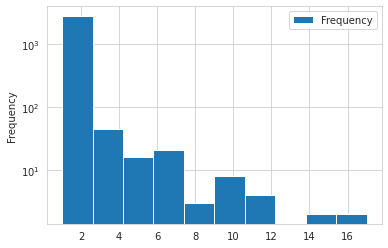

In [41]:
# Comparar com a tabela acima as frequencias
tax_freq_df.plot.hist(log=True)

---